### Neeraj Madan. Thanks to Kofi Baah, Nam Nguyen and Dr Martin Benning.
In this project, we use data from the Titanic Challenge on Kaggle. The goal is to apply machine learning model to predict the survivability of a given passenger based on some of the information such as their ages, genders and ticket fares. 
Throughout this notebook, we will first explore and analyze the dataset with the help of visualization. Then I will follow with processing the data and finally present the machine learning model we write

### Import some essentials libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
#my version of seaborn is 0.9.0. So if you have a lower version, there may be some graphs that can not be plotted 
%matplotlib inline

In [2]:
sns.__version__ #>= 0.9.0

'0.9.0'

In [3]:
train= pd.read_csv('train.csv')

In [4]:
train.shape

(891, 12)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.isnull().sum() #finding number of NaN

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- As we can see, one of the biggest challenge of this dataset is the missing values. There are many of them and there is even a column mostly filled with null values. We will go through the analysis of our dataset to find further information that may help us overcome this challenge.

# Data Dictionary

- Survived: 0 = No, 1 = Yes
- pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- ticket: Ticket number
- cabin: Cabin number
- embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

# Data Visualization and Exploration
In this step, we will create graphs to spot some insights out of the data and develop our hypothesises from those charts

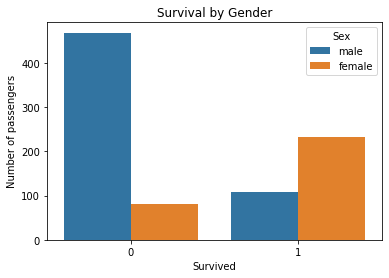

In [7]:
sns.countplot(x='Survived', hue= 'Sex', data= train).set_title('Survival by Gender')
plt.ylabel('Number of passengers')
plt.show()

- The chart shows that women are more likely to survive than men

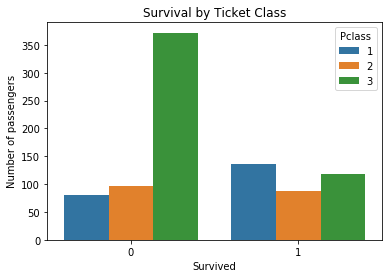

In [8]:
sns.countplot(x='Survived', hue= 'Pclass', data= train).set_title('Survival by Ticket Class')
plt.ylabel('Number of passengers')
plt.show()

- The chart confirms that people in Third class are more likely to die. On the other hand, peole in First class are more likely to survive

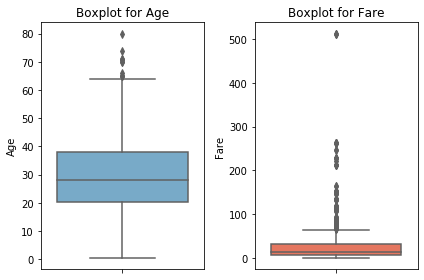

In [9]:
fig1, axs = plt.subplots(1,2)
sns.boxplot(train['Age'],orient='v', palette='Blues', ax=axs[0]).set_title('Boxplot for Age')
sns.boxplot(train['Fare'],orient='v',palette='Reds', ax=axs[1]).set_title('Boxplot for Fare')
fig1.tight_layout()
plt.show()

- There are many ouliers in Age and Fare. This may have negative impact on the target we want to classify in our model. We do not want this to happen. Hence, we can standardise these two variables to solve this issue

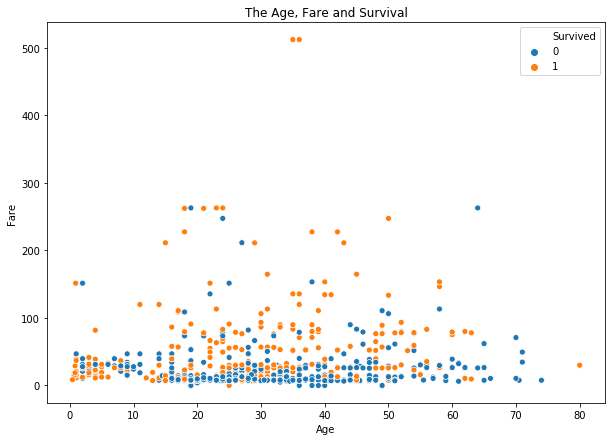

In [10]:
fig = plt.figure(figsize=(10,7))
sns.scatterplot(x='Age', y='Fare',data=train, hue='Survived').set_title('The Age, Fare and Survival')
plt.show()

- The scatter plot shows that children whose ages are less than 10 are the most likely to survive. Moreover, people with a higher ticket fare have more probability to survive

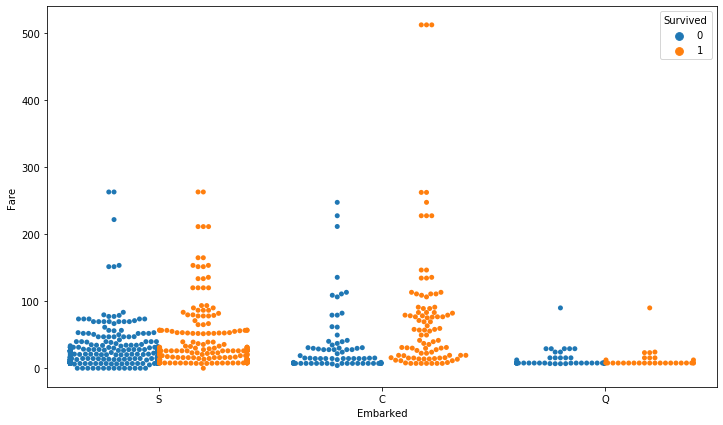

In [11]:
fig = plt.figure(figsize=(12,7))
sns.swarmplot(x='Embarked', y='Fare', hue='Survived', data=train, dodge=True)
plt.show()

- The graph above is a beeswarm plot. The plot is similiar to a scatter plot which displays each record as a point. The difference between these two kinds is the beeswarm plot makes the points further apart to avoid overlap $^{[1]}$
- The graph shows the different characteristics of the three ports. Most people embarked from Southamption in contrast to Queenstown, which has the fewest people. This was useful when we fill in the missing data for this column. The embarkation Cherbourg has a wider range of fare tickets and people who paid the most survived. 

In the data, we have two columns, SibSp and Parch. They shows the numbers of spouses, sibling, children and parents of indiviual passengers. We can actually combine these fields into another field that displays the number of family members for each passenger. We will name the field as 'FamSize'.

In [12]:
train['FamSize']= train['SibSp'] + train['Parch'] + 1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


Hence, let's explore how family size is related to the probability of survival for each passenger

<Figure size 720x504 with 0 Axes>

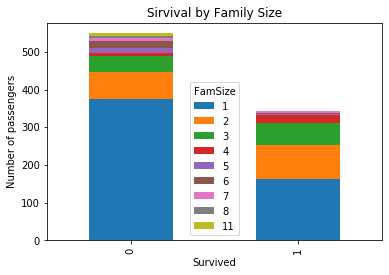

In [13]:
famsize_plot = train.groupby(['FamSize', 'Survived']).size().reset_index().pivot(columns='FamSize', index='Survived', values=0)
fig = plt.figure(figsize=(10,7))
famsize_plot.plot(kind='bar',stacked=True)
plt.title('Sirvival by Family Size')
plt.ylabel('Number of passengers')
plt.show()

- Passengers whose family size is 1 were less likely to survive. Thus, being single on board can be a contributing factor for our model

With the analysis above, we display features which will be included in our model. We will then modify the data

# Filling missing values


In [14]:
train.isnull().sum() #finding number of NaN

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamSize          0
dtype: int64

These are the numbers of missing values in each column. We have three columns that contain missing values: Age, Embarked and Cabin

For Age, we will use the median Age to fill in the missing data. However, it might not be a good approximation if we use the median of the whole sample. Therefore, we find the median ages of groups based on passengers' gender and ticket class to get a closer approximation. 

For Embarked, we fill the missing values with the most frequent values. Although this method is simple, it might not affect our model significantly since there are only 2 null values in this column.

For Cabin, since the column misses 80% of the data, it can be hard to esimate these values. Therefore, to avoid a large error for our model we will drop the column.

### Filling Age

In [15]:
groups=train.groupby(['Sex','Pclass']) #grou by Sex and Pclass
groups['Age'].median()

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [16]:
train['Age']=groups['Age'].apply(lambda x: x.fillna(x.median())) # fill the median value above to the missing field

### Filling Embarked

In [17]:
train['Embarked'].value_counts() #finding the values' frequencies

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- So most people embarked from Southampton

In [18]:
train['Embarked'].fillna('S', inplace= True) #fill in the missing value

In [19]:
train.drop('Cabin',axis=1,inplace= True) #droping Cabin

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
FamSize        891 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 83.6+ KB


- As a result, the data no longer contains any missing values

# Feature Engineering



In this step, we will adjust the data to be compatible with the algorithm for our model

In [21]:
train.head() #let's look at the data again

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


### Dummy variable:
- A dummy variable is a numerical variable that represents categrorical data which can be gender in this example. Usually, a dummy variable stores a value of 1 or 0 where 1 represents the presence of a qualitative attribute and 0 represents the absence. The number of dummy variables depends on the number of different categories. For example if a variable has k different values then k-1 dummy variables would be needed to represent this variable. $^{[2]}$

- For our dataset, we will use dummy variables on Sex, Ticket Class, Embarkment and Single Status

In [22]:
def getdummy(feature,drop=True):
    dummy=pd.get_dummies(train[feature], drop_first= drop)
    return dummy

In [23]:
sex= getdummy('Sex')
pclass= getdummy('Pclass')
embarked= getdummy('Embarked')
single= getdummy('FamSize', drop=False)[1]

In [24]:
train_fe=pd.concat([train,sex,pclass,embarked,single],axis=1)
train_fe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamSize,male,2,3,Q,S,1
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,1,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0,0,1,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,1,0,1,0,1,1


- We have columns, named "2" and "3" which represent ticket class. Column "1" shows if a passenger boarded alone (1 for yes, 0 for no). To avoid confusion, we changed the name of "1", "2" and "3" as follows: "Single", "2nd", "3rd" respectively.

In [25]:
train_fe.rename(columns={2:'2nd',3:'3rd',1:'Single'}, inplace=True)
train_fe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamSize,male,2nd,3rd,Q,S,Single
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2,1,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0,0,1,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,1,0,1,0,1,1


### Standardize Numerical Data
- This is a process of formatting a variable such that its mean and standard deviation are rescaled to 0 and 1 respectively$^{[3]}$. This process helps eliminate the impact of outliers on the predicted value of a model. To standardize a variable, each variable is subtracted by the mean and then divided by the standard deviation
$$x^{*}_i=\frac{x_i-\mu(x) }{\sigma(x)}$$

- As stated above, we may have some problems with outliers in Age and Fare. Therefore, standardising those two variables can solve the problem

In [26]:
train_fe.drop(['Age','Fare'],axis=1,inplace=True) #to avoid any confusion we concatenate the standardised values to our dataframe
train_fe.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,FamSize,male,2nd,3rd,Q,S,Single
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,S,2,1,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C,2,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,S,1,0,0,1,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,S,2,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,S,1,1,0,1,0,1,1


In [27]:
def standardise(x):
    mean=np.mean(x,axis=0)
    std=np.std(x,axis=0)
    x=(x-mean)/std
    return x

age_norm= standardise(train['Age'])
fare_norm= standardise(train['Fare'])
train_fe=pd.concat([train_fe, age_norm, fare_norm],axis=1)
train_fe.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,FamSize,male,2nd,3rd,Q,S,Single,Age,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,S,2,1,0,1,0,1,0,-0.534891,-0.502445
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C,2,0,0,0,0,0,0,0.668392,0.786845
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,S,1,0,0,1,0,1,1,-0.234070,-0.488854
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,S,2,0,0,0,0,1,0,0.442776,0.420730
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,S,1,1,0,1,0,1,1,0.442776,-0.486337


- We can remove columns unnecessary to our model. As shown above, we adopt a new dataframe to make the data easily fit to our model

In [28]:
train_fe.drop(['PassengerId','Sex','SibSp','Parch','Ticket','FamSize','Embarked','Name','Pclass'],axis=1,inplace= True)
train_fe.head()

,Survived,male,2nd,3rd,Q,S,Single,Age,Fare
0,0,1,0,1,0,1,0,-0.534891,-0.502445
1,1,0,0,0,0,0,0,0.668392,0.786845
2,1,0,0,1,0,1,1,-0.234070,-0.488854
3,1,0,0,0,0,1,0,0.442776,0.420730
4,0,1,0,1,0,1,1,0.442776,-0.486337


- Now the data is ready to be implemented

# Machine Learning Model

## Issues with Linear Regression for Classification 
![](LinearClass.png)
<h4><center>From An Introduction to Statistical Learning with Application 
                                    in R by James, Witten, Hastie and Tibshirani
</center></h4>


                                    

- For Binary Classification problems, the label should be in the interval [0,1]. However, the picture above shows that it is not always the case if we use Linear Regression. 
- This is because the fitted line is dependent on how many points each class has and the position each point lies on. For example, if we add points with y=1 and high balance, the line will be shifted. This property is not desirable

## Logistic Regression
- To solve the problem above, we can transform the prediction into a probability: 
- Instead of $\langle  \widetilde{x}_i,w \rangle $, we use $\sigma(\langle  \widetilde{x}_i,w \rangle)$ with 
$\sigma:(-\infty,\infty) \rightarrow [0,1]$ <br>
and $\sigma(\langle  \widetilde{x}_i,w \rangle)= Pr(\langle  \widetilde{x}_i,w \rangle)$ 
- In this case, we use the Logistic (or Sigmoid) function to convert the label: 
$$\sigma(z) =  \frac{\mathrm{e^z} }{\mathrm{1} + e^z } \qquad (1)$$

- Then we set up our threshold as the following <br>
    $Pr(\langle  \widetilde{x}_i,w \rangle) < \frac{1}{2} \Rightarrow$ the predicted output is in class with y=0 <br>
    $Pr(\langle  \widetilde{x}_i,w \rangle) > \frac{1}{2} \Rightarrow$ the predicted output is in class with y=1

- In our dataset, the label is considered with 1 and 0 which classifies if a passenger survived or not respectively. <br>
- Hence, we have input/output training sample $\{(x_i,y_i)\}^{s}_{i=1}$ with $y \in \{0,1\}$
- Our model is assumed to be linear: $f(x_i,w)= \langle  {x}_i,w \rangle + w_0= \langle  \widetilde{x}_i,w \rangle$
- As a result of the assumption, we have the two probability functions for each class
$$p(1|x)=\sigma(\langle  \widetilde{x}_i,w \rangle)$$
$$p(0|x)=1-\sigma(\langle  \widetilde{x}_i,w \rangle)$$



### Find the Loss function
- Here, our task is to find the loss function which contains the optimal parameter $\hat{w}$ given input/output sample $\{(x_i,y_i)\}^{s}_{i=1}$
- We assume: samples $(x_i,y_i)$ are independent and identically distributed
- Therefore, the likelihood function is:
$$p(y|X,w)=\prod_{i=1}^{s}p(y_i|x_i)$$
 for
$ \quad y:=\begin{pmatrix}
    y_1 \\
    y_2 \\
    \vdots \\
    y_s
    \end{pmatrix}  ,\; 
X:= \begin{pmatrix}
    |&|& &| \\
    \widetilde x_1 & \widetilde x_2 & \vdots & \widetilde x_s \\
    |&|& &|
    \end{pmatrix} ,\; 
\widetilde x_i:=\begin{pmatrix}
    1 \\
     x_{1i} \\
     x_{2i} \\
    \vdots \\
     x_{ni}
    \end{pmatrix}$
    

- These are some steps to derive the loss function from our lecture notes: <br>
$$p(y|X,w)=\prod_{i=1}^{s}p(y_i|x_i)$$
<br>
$$p(y|X,w)=\prod_{i:y_i=1}^{s} p(y_i=1 | x_i)
    \prod_{i:y_i=0}^{s} p(y_i=0|x_i)$$ 
<br>

<br>
We apply negative-log likelihood:
$$-log(p(y|X,w))=-log\left(
    \prod_{i=1}^{s}\sigma(\langle  \widetilde{x}_i,w \rangle)^{y_i}
    (1-\sigma(\langle  \widetilde{x}_i,w \rangle))^{1-y_i}
    \right)$$
Apply the product rule for logarithm:
$$-log(p(y|X,w))= -\sum_{i=1}^{s}
    \left[
    y_{i}log(\sigma(\langle  \widetilde{x}_i,w \rangle) +
    (1-y_i)log(1-\sigma(\langle  \widetilde{x}_i,w \rangle)
    \right]$$
Plug the sigmoid function from $(1)$ and with some further steps, we have the loss function as the following:
$$L(w)=\sum_{i=1}^{s}\left \{\left(log(1+exp(\langle \widetilde x_i,w \rangle)\right)-y_i\langle \widetilde x,w \rangle\right \}$$
This loss function is the negative-log likelihood 

Finally, the optimal value of $\hat{w}$ maximises the likelihood and it is also the value that minises our loss function
$$\hat{w}=\arg\min_{w} \{-log(p(y|X,w)\} \\ \Rightarrow
\hat{w} = \arg\min_{w} \left\{ \sum_{i=1}^{s}\left \{\left(log(1+exp(\langle \widetilde x_i,w \rangle)\right)-y_i\langle \widetilde x,w \rangle\right \} \right\} $$
And from our lecture, we have already showed that the loss function is convex $^{[4]}$. Thus, we can derive its gradient as below:
$$ \bigtriangledown L(w)= X^T(\sigma(Xw)-y)$$
<br>
Now we can write down functions to compute those equations above for our model

#### Alogrithm for negative log likelihood
- Sigmoid Function:  $\sigma(z) =  \frac{\mathrm{e^z} }{\mathrm{1} + e^z }$


- Loss Function: $L(w)=\sum_{i=1}^{s}\left \{\left(log(1+exp(\langle \widetilde x_i,w \rangle)\right)-y_i\langle \widetilde x,w \rangle\right \}$


- Gradient: $ \bigtriangledown L(w)= X^T(\sigma(Xw)-y)$

In [29]:
def sigmoid(z):
    sigmoid = (np.exp(z))/(1+np.exp(z))
    return sigmoid
    
def calculate_loss(y,tx,w):
    Z = tx.dot(w)
    g = np.log(1+np.exp(Z))
    Y = y*Z
    loss = np.sum(g-Y)
    return loss

def calculate_gradient(y,tx,w):
    sigz = sigmoid(tx.dot(w))
    return np.dot(tx.T,sigz-y)

### Gradient Descent:
This is our choice of opimisation as stated above, the loss function is differentiable and convex. <br>
The gradient descent for our logistic regression is:
$$w^{k+1}=w^k-\tau \bigtriangledown L(w)$$
     for some initial  $w_0$ 

## Ridge and Polynomial Regression
- To improve the accuracy of our model, we also introduce two more features to add in the initial original Loss function: They are Ridge and Polynomial Regression

###  Logistic Ridge Regression

- Loss Function: $L(w)=\sum_{i=1}^{s}\left \{\left(log(1+exp(\langle \widetilde x_i,w \rangle)\right)-y_i\langle \widetilde x,w \rangle\right \}+ \alpha\|w\|^2$


- Gradient: $ \bigtriangledown L(w)= X^T(\sigma(Xw)-y)+2\alpha w$

In [30]:
def penalised_logistic_regression(y, tx, w, alpha):
    grad= calculate_gradient(y,tx,w) + 2*alpha*w
    loss= calculate_loss(y,tx,w)+ alpha*(np.sum(w**2))
    return loss, grad


def learning_by_penalised_gradient(y, tx, w, tau, alpha):
    loss, grad = penalised_logistic_regression(y,tx,w,alpha)
    w= w-tau*grad
    return loss, w

### Polynomial Basis Function:
- Augmentation of input with polynomial basis of degree $d$:  $\phi(x_j)=\left(1\:x_1\:x^2_2\:...\:x^d_j\right)^T$


- Hence, our features will be transformed into this matrix: 
 $\Phi(X)=\begin{bmatrix}
           \phi(x_{1})^T \\
           \phi(x_{2})^T \\
           \vdots \\
           \phi(x_{s})^T
         \end{bmatrix} \in R^{(d+1)\times s}$ 
- Finally, our model becomes:
$$\hat{w}=\arg\min_{w}\sum_{i=1}^{s}\left \{\left(log(1+exp(\langle \phi(x_i),w \rangle)\right)-y_i\langle \phi(x),w \rangle\right \}+ \alpha\|w\|^2$$

In [31]:
def build_poly(x,degree):
    poly=np.ones((len(x),1))
    for deg in range(1,degree+1):
        poly=np.c_[poly,np.power(x,deg)]
    return poly

In [32]:
def polynomial_ridge_regression(y,x, tau,alpha, degree):
    """Constructing the polynomial basis function expansion of the data,
       and then running logistic regression."""
    # define parameters
    max_iter = 100000
    threshold = 1e-5
    tx=build_poly(x,degree)
    w=np.zeros((tx.shape[1],1))
    losses=[]
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalised_gradient(y, tx, w, tau, alpha)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # convergence criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    print("loss={l} \nw= {weight}".format(l=calculate_loss(y, tx, w), weight=w.T))

In [33]:
def polynomial_ridge_regression_getw(y,x, tau,alpha, degree):
    """Constructing the polynomial basis function expansion of the data,
       and then running logistic regression."""
    # define parameters
    max_iter = 10000
    threshold = 1e-5
    tx=build_poly(x,degree)
    w=np.zeros((tx.shape[1],1))
    losses=[]
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_penalised_gradient(y, tx, w, tau, alpha)
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return w

# Model Selection
- The optimal parameter is:
$$\hat{w}=\arg\min_{w}\sum_{i=1}^{s}\left \{\left(log(1+exp(\langle \phi(x_i),w \rangle)\right)-y_i\langle \phi(x),w \rangle\right \}+ \alpha\|w\|^2$$
Here, we have the choices of two hyperparameters, regularisation term Alpha and polynomial degree d. <br>
We need to determine the right values for these two to achieve the best predictive performance for our model. <br>
To ensure we do not overfit as the number of records in this case is relatively low (less than 1000), we adopted K-Fold Cross Validation.$^{[5]}$

### K-Fold Cross Validation
- We seperate the dataset randomly into k groups
- After splitting the data, we train the data k times, each time we leave 1 group for testing and k-1 groups for training
- Then we get the mean of k results
- Finally, we repeat these steps for each set of the hyperparameteres and use grid search to find the best one with the highest accuracy
- For this case, we test k=5
![](Kfold.png)
<h4><center>From Bishop. Pattern Recognition & Machine Learning
</center></h4>


### Choices of Alpha and Degree D
- We will run K-Fold Cross Validation on different set of the two hyperparameters
- The range for the regularisation parameter Alpha is from 0 to 10
- The range for the polynomial parameter d is between 1 and 7

#### Learning Rate
- We need to choose a suitable for each set of hyperparameters to run the alogrithm. If the learning rate is too small, it will be time consuming for the convergence for the local minimal. And if the rate is too large, the risk is the implementation will skip the minimum and hence the computer will not find the $\hat{w}$ to minise the loss function
- Therefore, we test to run our gradient descent with learning rates between $10^{-1}$ to $10^{-12}$ to find the best suited learning rate for each polynomial degree d
- After few rounds of trials, we find the best suited learning rates for each degree as they converge the loss function at the fastest rate (counting the number of iterations) 

In [34]:
data_tau={'Degree':[i for i in range(1,8)],'Learning Rate':[1e-3,1e-4,1e-4,1e-6,1e-8,1e-10,1e-12]}
df_tau=pd.DataFrame(data=data_tau)
df_tau

,Degree,Learning Rate
0,1,1.000000e-03
1,2,1.000000e-04
2,3,1.000000e-04
3,4,1.000000e-06
4,5,1.000000e-08
5,6,1.000000e-10
6,7,1.000000e-12


### Writing functions for K-Fold Cross Validation

In [35]:
def test_poly(x,w,degree):
    #creating function for testing
    prediction=[]
    tx=build_poly(x,degree)
    yhat=sigmoid(tx.dot(w))
    for i in yhat:
        if i >= 0.5:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction


def accuracy(prediction,y_test):
    #function for the accuracy of models
    correct=0
    for i in range(len(prediction)):
        if prediction[i]==y_test[i]:
            correct += 1
    return correct/len(prediction)

In [36]:
def k_fold_cross(k,data,tau,degree,alpha):
    scores=[]
    data=data.sample(frac=1,random_state=1).reset_index(drop=True) #shuffle the data frame
    folds=np.array_split(data, k)
    # run into loops with different test set
    for i in range(k):
        #define train and test 
        train=folds.copy()
        test=folds[i]
        del train[i]
        train=pd.concat(train, sort=False)
        
        #train x and y
        x_train=np.array(train.drop('Survived',axis=1))
        y_train=np.array(train[['Survived']])
        
        #test x and y
        x_test=np.array(test.drop('Survived',axis=1))
        y_test=np.array(test[['Survived']])
        
        #fitting training x and y into model
        weight=polynomial_ridge_regression_getw(y_train,x_train, tau,alpha,degree)
        
        #set up prediction and accuracy
        prediction=test_poly(x_test,weight,degree)
        probability=accuracy(prediction,y_test)
        scores.append(probability)
    return np.mean(scores)
        

In [67]:
def cross_poly_ridge(k=5):
    data=train_fe
    #creating list of recrods
    alpha_points=[]
    degree_points=[]
    scores=[]
    #define degrees and learning rates
    degrees=[i for i in range(1,8)]
    taus=[1e-3,1e-4,1e-4,1e-6,1e-8,1e-10,1e-12]
    #define alpha
    '''alphas=np.logspace(-5,0,6)
    alphas=list(alphas)
    alphas.remove(1.0)
    for i in range(0,11):
        alphas.append(i)'''
    alphas=np.linspace(0,10,21)
    #ridge regression with different alpha:
    for alpha in alphas:
        for degree, tau in zip(degrees,taus):
            mean_score=k_fold_cross(k,data,tau,degree,alpha)
            scores.append(mean_score)
            alpha_points.append(alpha)
            degree_points.append(degree)
    return alpha_points,degree_points,scores
            

In [68]:
Alpha,Degree,Probability=cross_poly_ridge(k=5)
Probability=[i*100 for i in Probability]
data_points={'Alpha':Alpha,'Degree':Degree,'Accuracy':Probability} 
results=pd.DataFrame(data=data_points)
results.head()

,Alpha,Degree,Accuracy
0,0.0,1,78.902768
1,0.0,2,80.025108
2,0.0,3,80.138096
3,0.0,4,70.827318
4,0.0,5,67.008349


In [86]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

def threed_graph(df):
    y=df['Alpha']
    x=df['Degree']
    z=df['Accuracy']
    fig=plt.figure(figsize=(15,7))
    ax=fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
    #Important: Add Labels
    ax.set_xlabel("Degree")
    ax.set_ylabel("Alpha")
    ax.set_zlabel("Accuracy")
    ax.set_title('Surface Plot of Accuracies by varying Degrees and Alphas')
    plt.show()

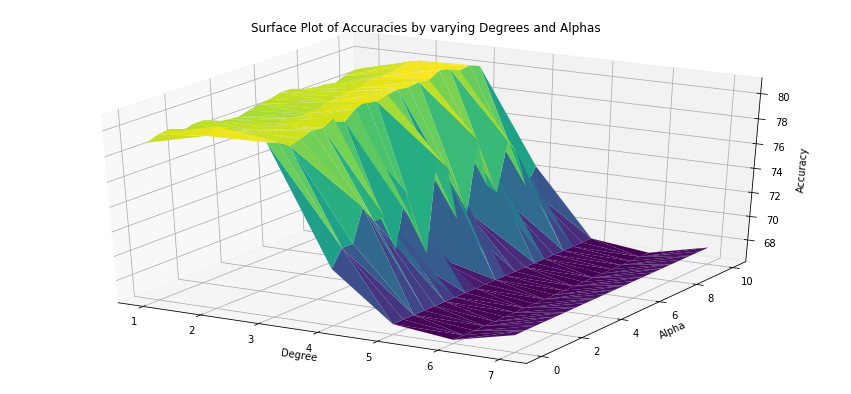

In [87]:
threed_graph(results)

- This graph illustrates effects of varying Alpha and Degree on Accuracy. As can be noticed, after degree = 3, the accuracy on the test set drops considerably. 
- Note there's little change in accuracy between a 1st, 2nd and 3rd degree polynomial. 
- In conclusion it would be interesting to see if there would be any difference at all between degree 1, 2, 3 given the rate of change in accuracy between those degrees is very small - however to ascertain this, we might require more datasets.

In [83]:
index=np.argmax(Probability)
print('The best accuracy is {p:.2f}% for Alpha={a} and Degree={d}'
      .format(p=max(Probability),
              a=Alpha[index],d=Degree[index]))

The best accuracy is 80.93% for Alpha=8.0 and Degree=3


- Hence, this is the set of hyperparameters to run our model for the dataset

# Reference
- Box Plot Alternatives: Beeswarm and Violin Plots (https://www.datascienceblog.net/post/data-visualization/boxplot_alternatives/) [1]
- Dummy Variables (https://stattrek.com/multiple-regression/dummy-variables.aspx) [2]
- How do I standardize variables in Stata? (https://stats.idre.ucla.edu/stata/faq/how-do-i-standardize-variables-in-stata/) [3]
- MTH786P Machine Learning with Python Lecture 5 p41-42 [4]
- Bishop, Pattern Recognition & Machine Learning p32 [5]